In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import sys
from copy import deepcopy
from dataclasses import dataclass, field
from pathlib import Path
from typing import List, Optional, Literal, Tuple
from torch import Tensor

import cv2
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import torch
import tqdm

from einops import rearrange
from jaxtyping import Float, Int

from neural_jacobian_field.inference import (
    CameraConfig,
    ModelConfig,
    ProgramConfig,
    CameraContext,
    load_model_cfg,
    load_model,
    load_nerfstudio_data,
    parse_nerfstudio_camera,
    plotting,
    action,
)
from neural_jacobian_field.rendering.geometry import (
    get_world_rays_with_z,
    project_world_coords_to_camera,
)
from neural_jacobian_field.data.dataset import (
    DatasetToyArmPointTrack,
    DatasetPneumaticPointTrack,
)

from neural_jacobian_field.visualization.view_interpolation import (
    interpolate_intrinsics,
    interpolate_pose,
    reproj_best_torch,
)
from PIL import Image

In [3]:
ROBOT_ACTION_DIMENSIONS = {
    "toy_arm": 6,
    "pneumatic_hand_only": 6,
}
ROBOT_DATASET_CLASS = {
    "toy_arm": DatasetToyArmPointTrack,
    "pneumatic_hand_only": DatasetPneumaticPointTrack,
}
ROBOT_TYPES = Literal["toy_arm", "allegro", "pneumatic_hand_only"]  # TODO: use enum

curr_robot_type: ROBOT_TYPES = "pneumatic_hand_only"
curr_model_type = "jacobian"

action_dim = ROBOT_ACTION_DIMENSIONS[curr_robot_type]
robot_dataset_cls = ROBOT_DATASET_CLASS[curr_robot_type]

In [4]:
data_config_path = Path(
    "./inference_demo_data/config/pneumatic_hand_config.json"
)


# TODO: modify cfg path and ckpt path appropriately.
args = ProgramConfig(
    ModelConfig(
        # note this is relative to the
        model_cfg_path=Path("../project/configurations/config"),
        model_ckpt_path=Path(f"../model_checkpoints/{curr_robot_type}/model.ckpt"),
    ),
    CameraConfig(
        ctxt_camera_idx=11,
        trgt_camera_idx=11,
        downscale_factor=1,
    ),
)

In [5]:
"""Load camera information"""

cameras, metadata = load_nerfstudio_data(
    data_path=data_config_path,
    downscale_factor=args.camera_config.downscale_factor,
)

camera_context = parse_nerfstudio_camera(
    cameras=cameras,
    ctxt_camera_idx=args.camera_config.ctxt_camera_idx,
    trgt_camera_idx=args.camera_config.trgt_camera_idx,
    device=args.device,
)
render_height = metadata["render_height"]
render_width = metadata["render_width"]

In [6]:
"""Load model"""

model_cfg = load_model_cfg(
    args.model_config.model_cfg_path,
    overrides=[
        f"model={curr_robot_type}",
        f"dataset={curr_robot_type}",
        f"model.action_model_type={curr_model_type}",
        f"model.action_dim={action_dim}",
        "model.train_encoder=False",
        "model.rendering.num_proposal_samples=[256]",
        "model.rendering.num_nerf_samples=256",
    ],
)

model = load_model(
    model_cfg=model_cfg,
    model_ckpt=args.model_config.model_ckpt_path,
    device=args.device,
)


z_near = torch.tensor([robot_dataset_cls.near], device=args.device)
z_far = torch.tensor([robot_dataset_cls.far], device=args.device)

/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Dropping parameter model.field.aabb
Dropping parameter model.proposal_networks.0.aabb


/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['model.field.jacobian_pred_head2.lin_in.weight', 'model.field.jacobian_pred_head2.lin_in.bias', 'model.field.jacobian_pred_head2.lin_out.weight', 'model.field.jacobian_pred_head2.lin_out.bias', 'model.field.jacobian_pred_head2.blocks.0.fc_0.weight', 'model.field.jacobian_pred_head2.blocks.0.fc_0.bias', 'model.field.jacobian_pred_head2.blocks.0.fc_1.weight', 'model.field.jacobian_pred_head2.blocks.0.fc_1.bias', 'model.field.jacobian_pred_head2.blocks.1.fc_0.weight', 'model.field.jacobian_pred_head2.blocks.1.fc_0.bias', 'model.field.jacobian_pred_head2.blocks.1.fc_1.weight', 'model.field.jacobian_pred_head2.blocks.1.fc_1.bias', 'model.field.jacobian_pred_head2.blocks.2.fc_0.weight', 'model.field.jacobian_pred_head2.blocks.2.fc_0.bias', 'model.field.jacobian_pred_head2.blocks.2.fc_1.weight', 'm

In [7]:
"""This part is tailor-made for visualizing the the chain-like structure of the toy robot"""

from einops import reduce

image_width, image_height = 640, 480


def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())


def denormalize_torch_image(img_tensor: torch.Tensor) -> np.ndarray:
    """
    Denormalize a [0, 1] torch image of shape [1, 3, H, W] to a numpy array of shape [H, W, 3]
    with values in the range [0, 255].

    Args:
        img_tensor (torch.Tensor): Input tensor image of shape [1, 3, H, W].

    Returns:
        np.ndarray: Denormalized image of shape [H, W, 3] with values in the range [0, 255].
    """
    # Denormalize
    img_numpy = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255.0
    # Convert to uint8
    img_numpy = img_numpy.astype(np.uint8)
    return img_numpy


def visualize_jacobian_chain_structure(
    input_image_np: Int[np.ndarray, "H W rgb"],
    input_joint_sensitivity_np: Float[Tensor, "action_dim H W"],
    joint_colors_np: Float[np.ndarray, "rgb action_dim"],
    debug: bool = False,
) -> Tuple[Int[np.ndarray, "H W rgb"], Int[np.ndarray, "H W rgb"]]:

    canvas_overlay = input_image_np.copy()

    list_of_diff_masks = []
    list_of_norm_projected = []

    for i in range(1, 5):
        prev_s = ((input_joint_sensitivity_np[i])).clip(0.08, 1.5)
        next_s = ((input_joint_sensitivity_np[i + 1])).clip(0.08, 1.5)
        diff = (prev_s - next_s).clip(0.01, 1)
        diff = normalize_image(diff)
        diff = cv2.resize(diff, (image_width, image_height))

        if debug:
            # create a 1x3 grid of plots
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            # draw
            ax[0].imshow(prev_s)
            ax[0].set_title("prev_s")
            ax[1].imshow(next_s)
            ax[1].set_title("next_s")
            ax[2].imshow(diff)
            ax[2].set_title("diff")
            fig.colorbar(ax[0].imshow(prev_s), ax=ax[0])
            fig.colorbar(ax[1].imshow(next_s), ax=ax[1])
            fig.colorbar(ax[2].imshow(diff), ax=ax[2])
            plt.show()

        projected = diff[..., None] * np.array(joint_colors_np[i])
        minima = reduce(projected, "C H W -> C () ()", "min")
        maxima = reduce(projected, "C H W -> C () ()", "max")

        norm_projected = (projected - minima) / (maxima - minima + 1e-10)
        norm_projected = (norm_projected * 255).clip(0, 255).astype(np.uint8)

        if debug:
            overlay = cv2.addWeighted(input_image_np, 0.5, norm_projected, 0.8, 0)
            plt.imshow(overlay)
            plt.show()

        list_of_diff_masks.append(diff)
        list_of_norm_projected.append(norm_projected)

    next_s = cv2.resize(next_s, (image_width, image_height))

    list_of_diff_masks.append(next_s.copy())
    next_s = normalize_image(next_s.clip(0.25, 1.0))

    projected = next_s[..., None] * np.array(joint_colors_np[i + 1])
    minima = reduce(projected, "C H W -> C () ()", "min")
    maxima = reduce(projected, "C H W -> C () ()", "max")

    norm_projected = (projected - minima) / (maxima - minima + 1e-10)
    norm_projected = (norm_projected * 255).clip(0, 255).astype(np.uint8)
    list_of_norm_projected.append(norm_projected)

    canvas_overlay = input_image_np.copy()
    canvas_overlay = cv2.cvtColor(canvas_overlay, cv2.COLOR_RGB2RGBA)
    canvas_overlay[..., 3] = 155
    canvas_overlay = Image.fromarray(canvas_overlay)

    canvas_white_bkgd = np.ones_like(input_image_np, dtype=np.uint8) * 255
    canvas_white_bkgd = cv2.cvtColor(canvas_white_bkgd, cv2.COLOR_RGB2RGBA)

    canvas_white_bkgd[..., 3] = 255
    canvas_white_bkgd = Image.fromarray(canvas_white_bkgd)

    for i in range(len(list_of_norm_projected)):
        norm_projected_rgba = cv2.cvtColor(
            list_of_norm_projected[i], cv2.COLOR_RGB2RGBA
        )
        diff = list_of_diff_masks[i]
        diff = normalize_image(diff)

        alpha_mask = diff * 1.5
        alpha_mask = (alpha_mask.clip(0, 1) * 255).astype(np.uint8)
        norm_projected_rgba[..., 3] = alpha_mask

        overlay = Image.fromarray(norm_projected_rgba)

        canvas_overlay.paste(overlay, (0, 0), overlay)
        canvas_white_bkgd.paste(overlay, (0, 0), overlay)

    return np.asarray(canvas_overlay), np.asarray(canvas_white_bkgd)

In [8]:
def render_single_view(
    input_image_th: Float[Tensor, "1 channel height width"],
    input_action_th: Float[Tensor, "1 dim"],
    input_camera_context: CameraContext,
    joint_colors_th: Float[Tensor, "rgb action_dim"],
    trgt_ros: Optional[Float[Tensor, "1 ray 3"]] = None,
    trgt_rds: Optional[Float[Tensor, "1 ray 3"]] = None,
    patch_size: int = 2048,
    compute_action_features: bool = True,
    zero_out_sensitivity_below_thresh: float = 0.0,
    zero_out_sensitivity_below_depth_percentile: int = 999,
    device: torch.device = torch.device("cuda:0"),
    verbose: bool = True,
):

    trgt_extrinsics = input_camera_context["trgt_c2w"].to(device).unsqueeze(0)
    ctxt_extrinsics = input_camera_context["ctxt_c2w"].to(device).unsqueeze(0)

    trgt_intrinsics = input_camera_context["trgt_intr"].to(device).unsqueeze(0)
    ctxt_intrinsics = input_camera_context["ctxt_intr"].to(device).unsqueeze(0)

    coordinates = input_camera_context["coordinates"].to(device)
    coordinates = input_camera_context["coordinates"].view(-1, 2).unsqueeze(0)

    if trgt_ros is None and trgt_rds is None:
        trgt_ros, trgt_rds, _ = get_world_rays_with_z(
            coordinates, trgt_intrinsics, trgt_extrinsics
        )

    model_outputs = model.patch_render(
        ctxt_image=input_image_th,
        robot_action=input_action_th,
        origins=trgt_ros,
        directions=trgt_rds,
        ctxt_c2w=ctxt_extrinsics,
        ctxt_intr=ctxt_intrinsics,
        trgt_c2w=trgt_extrinsics,
        trgt_intr=trgt_intrinsics,
        z_near=z_near,
        z_far=z_far,
        patch_size=patch_size,
        render_height=render_height,
        render_width=render_width,
        compute_action_features=compute_action_features,
        verbose=verbose,
    )

    joint_sensitivity_th = plotting.compute_joint_sensitivity(
        model_outputs["pred_feat"].squeeze(0),
        camera_context["ctxt_c2w"],
    )

    if zero_out_sensitivity_below_thresh > 0.0:
        joint_sensitivity_th[
            joint_sensitivity_th < zero_out_sensitivity_below_thresh
        ] = 0

    if zero_out_sensitivity_below_depth_percentile != 999:
        depth_original = model_outputs["pred_depth"].squeeze(0).cpu().numpy()
        # create binary mask using the prescribed threshold
        depth_thresh = np.percentile(
            depth_original, zero_out_sensitivity_below_depth_percentile
        )
        depth_mask = (depth_original > depth_thresh).squeeze(-1)
        joint_sensitivity_th[:, depth_mask] = 0

    if curr_robot_type == "toy_arm":
        input_image_np = denormalize_torch_image(input_image_th)
        pred_jacobian_overlay_rgb, pred_jacobian_rgb = (
            visualize_jacobian_chain_structure(
                input_image_np=input_image_np,
                input_joint_sensitivity_np=joint_sensitivity_th.cpu().numpy(),
                joint_colors_np=joint_colors_th.T.cpu().numpy(),
            )
        )
        model_outputs["pred_jacobian_overlay_rgb"] = pred_jacobian_overlay_rgb

    else:
        pred_jacobian_rgb = plotting.visualize_joint_sensitivity(
            joint_sensitivity_th=joint_sensitivity_th,
            joint_colors_th=joint_colors_th,
        )

    model_outputs["joint_sensitivity"] = joint_sensitivity_th
    model_outputs["pred_jacobian_rgb"] = pred_jacobian_rgb

    return model_outputs

In [9]:
def render_interpolated_view(
    input_image: Float[Tensor, "() channel height width"],
    input_action: Float[Tensor, "() dim"],
    input_camera_context: CameraContext,
    joint_colors_th: Float[Tensor, "rgb action_dim"],
    src_steps: Tensor,
    src_weights: Tensor,
    list_of_drawing_loc_x: List[Tensor],
    list_of_drawing_loc_y: List[Tensor],
    list_of_ray_positions: List[Tensor],
    list_of_ray_positions_warped: List[Tensor],
    patch_size: int = 2048,
    zero_out_sensitivity_below_thresh: float = 0.0,
    zero_out_sensitivity_below_depth_percentile: int = 999,
    num_frames_to_interpolate: int = 30,
    # flow parameters
    flow_vector_length_multiplier: int = 50,
    flow_vector_line_thickness: int = 3,
    # misc
    device: torch.device = torch.device("cuda:0"),
    verbose: bool = True,
):

    trgt_extrinsics = input_camera_context["trgt_c2w"].to(device)
    ctxt_extrinsics = input_camera_context["ctxt_c2w"].to(device)

    trgt_intrinsics = input_camera_context["trgt_intr"].to(device)
    ctxt_intrinsics = input_camera_context["ctxt_intr"].to(device)

    trgt_intrinsics_raw = input_camera_context["trgt_intr_raw"].to(device)
    ctxt_intrinsics_raw = input_camera_context["ctxt_intr_raw"].to(device)

    coordinates = input_camera_context["coordinates"].to(device)
    coordinates = input_camera_context["coordinates"].view(-1, 2)[None]

    output_video_dict = {
        k: []
        for k in (
            "pred_rgb",
            "pred_depth_rgb",
            "pred_jacobian_rgb",
            "pred_flow_rgb",
            "pred_arrow_rgb",
        )
    }
    output_video_dict["pred_arrow_rgb"] = [
        [] for _ in range(len(list_of_drawing_loc_x))
    ]

    for t in tqdm.tqdm(
        torch.linspace(0, 1, num_frames_to_interpolate), desc="Rendering video frames"
    ):
        # Apply smoothing.
        t = (math.cos(math.pi * (t.item() + 1)) + 1) / 2

        # Video validation always uses a batch size of 1.
        interp_trgt_c2w = interpolate_pose(
            trgt_extrinsics,
            ctxt_extrinsics,
            t,
        )[None]

        interp_trgt_intr = interpolate_intrinsics(
            trgt_intrinsics,
            ctxt_intrinsics,
            t,
        )[None]

        interp_trgt_intr_raw = interpolate_intrinsics(
            trgt_intrinsics_raw,
            ctxt_intrinsics_raw,
            t,
        )[None]

        origins, directions, _ = get_world_rays_with_z(
            coordinates, interp_trgt_intr, interp_trgt_c2w
        )

        xy_B_map_for_t = reproj_best_torch(
            src_steps=src_steps,
            src_weights=src_weights,
            src_c2w=ctxt_extrinsics,
            tgt_c2w=interp_trgt_c2w[0],
            src_intrinsics=ctxt_intrinsics_raw,
            tgt_intrinsics=interp_trgt_intr_raw[0],
        )

        with torch.no_grad():

            total_pred_outputs = render_single_view(
                input_image_th=input_image,
                input_action_th=input_action,
                input_camera_context=input_camera_context,
                joint_colors_th=joint_colors_th,
                trgt_ros=origins,
                trgt_rds=directions,
                compute_action_features=True,
                zero_out_sensitivity_below_thresh=zero_out_sensitivity_below_thresh,
                zero_out_sensitivity_below_depth_percentile=zero_out_sensitivity_below_depth_percentile,
                patch_size=patch_size,
                device=device,
                verbose=verbose,
            )

            pred_rgb = total_pred_outputs["pred_rgb"].cpu().numpy()[0]
            pred_flow_rgb = total_pred_outputs["pred_flow_rgb"].cpu().numpy()[0]
            pred_depth_rgb = total_pred_outputs["pred_depth_rgb"].cpu().numpy()[0]
            pred_jacobian_rgb = total_pred_outputs["pred_jacobian_rgb"]

            output_video_dict["pred_rgb"].append(pred_rgb)
            output_video_dict["pred_flow_rgb"].append(pred_flow_rgb)
            output_video_dict["pred_depth_rgb"].append(pred_depth_rgb)
            output_video_dict["pred_jacobian_rgb"].append(pred_jacobian_rgb)

            for item_idx in range(len(list_of_drawing_loc_x)):
                drawing_loc_x = list_of_drawing_loc_x[item_idx]
                drawing_loc_y = list_of_drawing_loc_y[item_idx]
                ray_positions = list_of_ray_positions[item_idx]
                ray_positions_warped = list_of_ray_positions_warped[item_idx]

                pix_to_draw_x, pix_to_draw_y = xy_B_map_for_t[
                    drawing_loc_y, drawing_loc_x
                ].split(1, dim=-1)

                uv = project_world_coords_to_camera(
                    ray_positions, interp_trgt_c2w, interp_trgt_intr_raw
                )
                uv_warped = project_world_coords_to_camera(
                    ray_positions_warped, interp_trgt_c2w, interp_trgt_intr_raw
                )

                optical_flow_projected = uv_warped - uv

                flow_arrow_rgb = plotting.draw_flow_on_image(
                    curr_frame=pred_jacobian_rgb[..., :3].copy(),
                    pix_to_draw_y=pix_to_draw_y,
                    pix_to_draw_x=pix_to_draw_x,
                    flow_pred_combined=optical_flow_projected,
                    color_map_choice="cool",
                    length_multiplier=flow_vector_length_multiplier,
                    line_thickness=flow_vector_line_thickness,
                    use_norm=True,
                )

                output_video_dict["pred_arrow_rgb"][item_idx].append(flow_arrow_rgb)

    # if list_of_drawing_loc_x is not None:

    output_video_dict["pred_arrow_rgb"] = [
        np.stack(x, axis=0) for x in output_video_dict["pred_arrow_rgb"]
    ]

    for key in ("pred_rgb", "pred_depth_rgb", "pred_flow_rgb", "pred_jacobian_rgb"):
        output_video_dict[key] = np.stack(output_video_dict[key], axis=0)  # type: ignore

    return output_video_dict

In [10]:
def sample_pix_xy_from_mask(mask, num_points: int = 100):

    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()

    x, y = mask.nonzero()
    indices = np.stack([x, y], axis=1)

    np.random.shuffle(indices)
    indices = indices[:num_points]

    query_points = np.concatenate(
        (np.zeros((indices.shape[0], 1)), indices), axis=-1
    ).astype(np.int32)

    return query_points

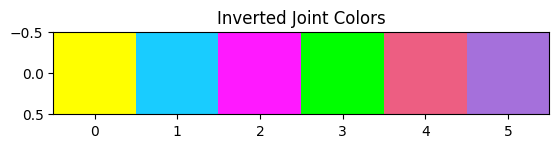

In [11]:
joint_colors_np = [
    # [0.1, 0.8, 0.8],
    # [0.1, 0.5, 0.8],
    [0, 0, 1],
    [0.9, 0.2, 0.0],
    [0, 0.9, 0],
    [1.0, 0.0, 1.0],
    [0.1, 0.9, 0.7],
    [0.5, 0.8, 0.2],
]

joint_colors_np = np.array(joint_colors_np)
joint_colors_np[-2:] *= 0.7

# visualize the joint_colors_np to check
plt.imshow(1 - np.array([joint_colors_np]))
plt.title("Inverted Joint Colors")
plt.show()

joint_colors_th = torch.tensor(joint_colors_np).T.to(args.device).float()
ctxt_camera_idx = args.camera_config.ctxt_camera_idx
trgt_camera_idx = args.camera_config.trgt_camera_idx

In [12]:
"""Load some data and start inference"""

from neural_jacobian_field.utils.io import numpy_to_torch_image, load_gzip_file

inference_demo_data: dict = load_gzip_file(
    "./inference_demo_data/optimization_demo_pneumatic_hand.pkl"
)
print(inference_demo_data.keys())

input_image_np = inference_demo_data["curr_frame"]
curr_pix_locs = inference_demo_data["curr_pix_locs"]
trgt_pix_locs = inference_demo_data["trgt_pix_locs"]

dict_keys(['curr_pix_locs', 'trgt_pix_locs', 'curr_frame'])


In [13]:
### We are reloading cameras to make trgt = ctxt
camera_context = parse_nerfstudio_camera(
    cameras=cameras,
    ctxt_camera_idx=args.camera_config.ctxt_camera_idx,
    trgt_camera_idx=args.camera_config.ctxt_camera_idx,
    device=args.device,
)

input_action_place_holder_th = torch.zeros((1, action_dim,)).to(args.device)

input_image_th = numpy_to_torch_image(input_image_np).unsqueeze(0).to(args.device)

# making trgt view the same as input view
ctxt_extrinsics = camera_context["ctxt_c2w"].to(args.device)
trgt_extrinsics = ctxt_extrinsics.clone()
# trgt_extrinsics = camera_context["trgt_c2w"].to(args.device)

ctxt_intrinsics = camera_context["ctxt_intr"].to(args.device)
trgt_intrinsics = camera_context["trgt_intr"].to(args.device)

coordinates = camera_context["coordinates"].to(args.device)
coordinates = camera_context["coordinates"].view(-1, 2)

trgt_ros, trgt_rds, _ = get_world_rays_with_z(
    coordinates[None], trgt_intrinsics[None], trgt_extrinsics[None]
)

model_outputs = render_single_view(
    input_image_th=input_image_th,
    input_action_th=input_action_place_holder_th,
    input_camera_context=camera_context,
    joint_colors_th=joint_colors_th,
    trgt_ros=trgt_ros,
    trgt_rds=trgt_rds,
    patch_size=2048,
    compute_action_features=True,
    zero_out_sensitivity_below_depth_percentile=90,
)


  1%|          | 1/150 [00:00<00:30,  4.95it/s]

100%|██████████| 150/150 [00:15<00:00,  9.52it/s]


,

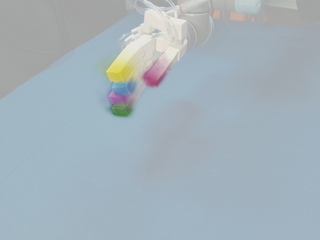
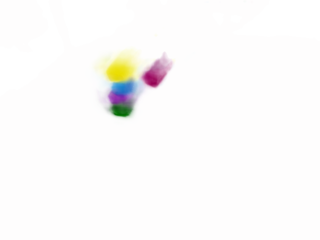

In [14]:
pred_jacobian_rgba = model_outputs["pred_jacobian_rgb"][..., :4]
pred_jacobian_rgb = model_outputs["pred_jacobian_rgb"][..., :3]

input_image_np_rgba = cv2.cvtColor(input_image_np, cv2.COLOR_RGB2RGBA)

overlay = cv2.addWeighted(input_image_np_rgba, 0.3, pred_jacobian_rgba, 0.6, 0)
media.show_images(
    [overlay, pred_jacobian_rgb],
    height=render_height // 2,
    width=render_width // 2,
)

""

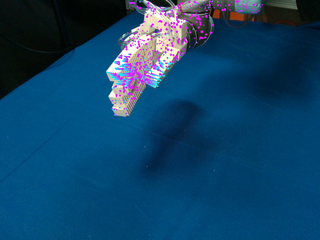

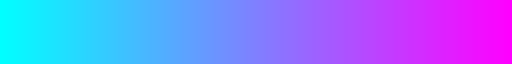

In [15]:
from matplotlib import cm

# this model is only trained on hand motions only, so it is not sensitivty to the arm
point_matching_image_np = plotting.draw_point_matching_on_image(
    input_image_np,
    curr_pix_locs=curr_pix_locs,
    trgt_pix_locs=trgt_pix_locs,
    color_map_choice="cool",
    line_thickness=2,
)

media.show_image(
    point_matching_image_np,
    height=render_height // 2,
    width=render_width // 2,
)

cm.get_cmap("cool")

In [16]:
"""
    Start trial
"""

from neural_jacobian_field.utils.io import numpy_to_torch_image


optim_iter = 65
optim_lr = 1e-1
action_dim = 6
action_init_var = 0.0

trgt_pix_flow = trgt_pix_locs - curr_pix_locs


ctxt_c2w = camera_context["ctxt_c2w"][None].to(args.device)
trgt_c2w = camera_context["trgt_c2w"][None].to(args.device)
ctxt_intr = camera_context["ctxt_intr"][None].to(args.device)
trgt_intr = camera_context["trgt_intr"][None].to(args.device)

coordinates = camera_context["coordinates"][None]
coordinates = rearrange(coordinates, "b h w c -> b (h w) c")


ctxt_ros, ctxt_rds, z_values = get_world_rays_with_z(
    coordinates_xy=coordinates,
    cam2world=ctxt_c2w,
    intrinsics=ctxt_intr,
)

# casting everything to torch
curr_pix_locs_th = torch.from_numpy(np.asarray(curr_pix_locs)).to(args.device).float()
trgt_pix_flow_th = torch.from_numpy(np.asarray(trgt_pix_flow)).to(args.device).float()


predicted_action, _ = action.optimize_actions(
    model=model,
    camera_context=camera_context,
    ctxt_image=numpy_to_torch_image(input_image_np).to(args.device),
    z_near=z_near,
    z_far=z_far,
    origins=ctxt_ros,
    directions=ctxt_rds,
    curr_pix_locs=curr_pix_locs_th,
    trgt_pix_flow=trgt_pix_flow_th,
    num_optim_iter=optim_iter,
    learning_rate=optim_lr,
    action_dim=action_dim,
    action_init_var=action_init_var,
)


  0%|          | 0/65 [00:00<?, ?it/s]/home/scene-rep-robot/scratch/neural-jacobian-field/project/neural_jacobian_field/inference/action.py:77: UserWarning: Using a target size (torch.Size([500, 2])) that is different to the input size (torch.Size([1, 500, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(
loss: 3.5924899578094482 | dq_reg: 0.0: 100%|██████████| 65/65 [00:00<00:00, 475.65it/s]


In [17]:
"""
As observed, only the first channel (First Finger), 
and the last two channels (THUMB) have large positive values. 

This is correct since our desired motions are concentrated on these two fingers.
"""

print(predicted_action)

tensor([[ 0.3904,  0.0432, -0.0688, -0.0075,  0.5753,  0.3934]],
       device='cuda:0')


In [18]:
"""
Let's visualize the predicted motions and compare them against the desired ones
"""

### We are reloading cameras to make trgt = ctxt
camera_context = parse_nerfstudio_camera(
    cameras=cameras,
    ctxt_camera_idx=args.camera_config.ctxt_camera_idx,
    trgt_camera_idx=args.camera_config.ctxt_camera_idx,
    device=args.device,
)

input_image_th = numpy_to_torch_image(input_image_np).unsqueeze(0).to(args.device)

# making trgt view the same as input view
ctxt_extrinsics = camera_context["ctxt_c2w"].to(args.device)
trgt_extrinsics = ctxt_extrinsics.clone()
# trgt_extrinsics = camera_context["trgt_c2w"].to(args.device)

ctxt_intrinsics = camera_context["ctxt_intr"].to(args.device)
trgt_intrinsics = camera_context["trgt_intr"].to(args.device)

coordinates = camera_context["coordinates"].to(args.device)
coordinates = camera_context["coordinates"].view(-1, 2)

trgt_ros, trgt_rds, _ = get_world_rays_with_z(
    coordinates[None], trgt_intrinsics[None], trgt_extrinsics[None]
)

model_outputs = render_single_view(
    input_image_th=input_image_th,
    input_action_th=predicted_action,
    input_camera_context=camera_context,
    joint_colors_th=joint_colors_th,
    trgt_ros=trgt_ros,
    trgt_rds=trgt_rds,
    patch_size=2048,
    compute_action_features=True,
    zero_out_sensitivity_below_depth_percentile=90,
)


  5%|▌         | 8/150 [00:00<00:14,  9.58it/s]

100%|██████████| 150/150 [00:15<00:00,  9.57it/s]


,

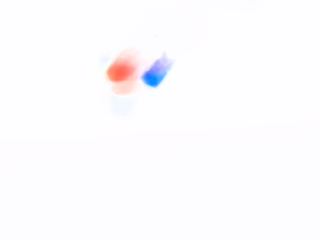
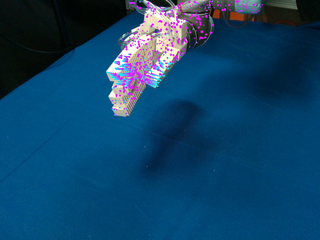

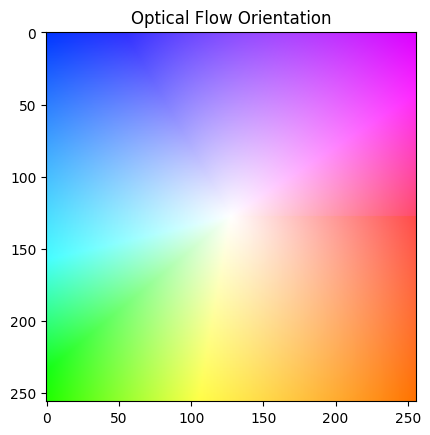

In [19]:
"""
We are getting results consistent with our desired motions!
"""

pred_flow_rgb = model_outputs["pred_flow_rgb"].squeeze().cpu().numpy()
media.show_images(
    [pred_flow_rgb, point_matching_image_np],
    height=render_height // 2,
    width=render_width // 2,
)

# visualize the optical flow wheel
plt.imshow(
    media.read_image("./inference_demo_data/flow_legend.png"), 
)
plt.title("Optical Flow Orientation")
plt.show()